## ToDo

- Get a single simulation frame from a mixture of two molecules with several different atom types
- Calculate the energies and forces with the MACE-OMOL model
- Train to this and experiment with e.g. starting the parameters off in crazy places
- Contrast to training directly to condensed-phase properties -- do we better constrain the parameters?

## Some relevant literature

- Li et al. 2017 https://pubs.acs.org/doi/full/10.1021/acs.jctc.7b00521?casa_token=m6sk8hlrDu4AAAAA%3A3xx-_ZcGn07fcu6DHByQ1Sp3R4Q9QgtHUQ-06z7TLrrjSUREzgSouJq3t4bAwDCZxB0j4hHBe45J-xY
- Mezei 1991 https://pubs.acs.org/doi/pdf/10.1021/j100171a059?casa_token=MKxe9HP2QNcAAAAA:FWnsQgXW4n6WNvwVXMnsqAI_UMpU7zAOVak3CpWepkCNI_69AMy36t0HQIVRj4feL17BfZQ0FwL7lE0#page=8.34
- Izvekov, Parrinello et al. https://pubs.aip.org/aip/jcp/article-abstract/120/23/10896/981116/Effective-force-fields-for-condensed-phase-systems

Let's try and copy Li et al.

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
import smee
import smee.mm
import smee.converters
from openff.toolkit import Molecule, ForceField
from openff.interchange import Interchange
import tempfile
import openmm.unit
from pathlib import Path
import torch
from openmmml import MLPotential
import mdtraj
from tqdm import tqdm
import descent
import descent.utils.reporting
import descent.train
import matplotlib.pyplot as plt
import numpy as np

SMILES = "[C:1]([H:3])([H:4])([H:5])[O:2][H:6]"
N_ATOMS_PER_MOL = Molecule.from_mapped_smiles(SMILES).n_atoms
N_MOL = 323
mol = Molecule.from_mapped_smiles(SMILES)
FF_NAME = "openff_unconstrained-2.2.1.offxml"
FF_NAME = "de-force-1.0.3.offxml"
# FF_NAME = "../../input_ff/openff_unconstrained-2.2.0_zeroed.offxml"
MLP_NAME = "mace-off24-medium"
TRAJECTORY_PATH = Path("methanol_perturbed_rand0/trajectory.tr")
# TRAJECTORY_PATH = Path("methanol_sage221_unconstrained/trajectory.tr")
TRAINED_TRAJECTORY_PATH = Path(
    "methanol_perturbed_rand0_wider_final_ff/trajectory_trained.tr"
)
TEMPERATURE = 300 * openmm.unit.kelvin
PRESSURE = 1.0 * openmm.unit.atmosphere

mlp = MLPotential(MLP_NAME)


def perturb_tensor(
    tensor: torch.Tensor, frac: float = 0.2, mode: str = "add"
) -> torch.Tensor:
    """
    Perturb a tensor by a random factor in [1-frac, 1+frac].

    Parameters
    ----------
    tensor : torch.Tensor
        The tensor to perturb.
    frac : float
        The fraction of the tensor to perturb.
    mode : str
        The mode of perturbation. Can be "add" or "mul".
    """
    assert mode in ["add", "mul"], "Mode must be 'add' or 'mul'"
    mode_ref = 1.0 if mode == "mul" else 0.0
    factor_low = mode_ref - frac
    factor_high = mode_ref + frac

    # Fix random seed for reproducibility
    torch.manual_seed(0)
    noise = torch.empty_like(tensor).uniform_(factor_low, factor_high)
    with torch.no_grad():
        if mode == "add":
            tensor.add_(noise)
        elif mode == "mul":
            tensor.mul_(noise)
    return tensor.abs()

### Run a simulation of methanol with Sage 2.2.1 unconstrained at 298 K/ 1 atm

Mainly stolen from https://github.com/SimonBoothroyd/smee/blob/aca69b9da4c67916c6e59ed2c435fffd4c49a2b6/examples/md-simulations.ipynb

In [ ]:
# Need TensorSystem, TensorForceField, and Simulation config

# Get the TensorySystem
force_field = ForceField(FF_NAME, load_plugins=True)
interchange = Interchange.from_smirnoff(
    force_field,
    [Molecule.from_smiles(SMILES)],
)

tensor_ff, topologies = smee.converters.convert_interchange(interchange)
initial_vdw_params = tensor_ff.potentials_by_type["vdW"].parameters.detach().clone()
# Perturb the initial parameters
# tensor_ff.potentials_by_type["vdW"].parameters = perturb_tensor(
#    tensor_ff.potentials_by_type["vdW"].parameters, frac=0.2
# )
print("Initial parameters:")
print(initial_vdw_params)
print("Perturbed parameters:")
print(tensor_ff.potentials_by_type["vdW"].parameters)


# move the force field to the GPU for faster processing of the simulation
# trajectories - the system and force field must be on the same device.
tensor_ff = tensor_ff.to("cuda")

vdw_potential = tensor_ff.potentials_by_type["vdW"]
vdw_potential.parameters.requires_grad = True

system = smee.TensorSystem([topologies[0]], [N_MOL], is_periodic=True)

# Create a trainable object
vdw_parameter_config = descent.train.ParameterConfig(
    cols=["epsilon", "r_min"],
    scales={"epsilon": 10.0, "r_min": 1.0},
    limits={"epsilon": (None, None), "r_min": (0.0, None)},
)

trainable = descent.train.Trainable(
    force_field=tensor_ff, parameters={"vdW": vdw_parameter_config}, attributes={}
)

# Get the Simulation config
beta = 1.0 / (openmm.unit.MOLAR_GAS_CONSTANT_R * TEMPERATURE)

# we can run an arbitrary number of equilibration simulations / minimizations.
# all generated data will be discarded, but the final coordinates will be used
# to initialize the production simulation
equilibrate_config = [
    smee.mm.MinimizationConfig(),
    # short NVT equilibration simulation
    smee.mm.SimulationConfig(
        temperature=TEMPERATURE,
        pressure=None,
        n_steps=50_000,
        timestep=1.0 * openmm.unit.femtosecond,
    ),
    # short NPT equilibration simulation
    smee.mm.SimulationConfig(
        temperature=TEMPERATURE,
        pressure=PRESSURE,
        n_steps=50_000,
        timestep=1.0 * openmm.unit.femtosecond,
    ),
]
# long NPT production simulation
production_config = smee.mm.SimulationConfig(
    temperature=TEMPERATURE,
    pressure=PRESSURE,
    n_steps=1_000_000,
    # n_steps=10_000,
    timestep=1.0 * openmm.unit.femtosecond,
)

/tmp/ipykernel_3890669/1329898006.py:7: AtomMappingWarning: Warning! Fully mapped SMILES pattern passed to `from_smiles`. The atom map is stored as a property in `Molecule._properties`, but these indices are NOT used to determine atom ordering. To use these indices for atom ordering, use `Molecule.from_mapped_smiles`.
  [Molecule.from_smiles(SMILES)],


Initial parameters:
tensor([[0.1122, 3.7925],
        [0.0229, 2.8378],
        [0.2093, 3.3335],
        [0.0000, 1.0000]], dtype=torch.float64)
Perturbed parameters:
tensor([[0.1122, 3.7925],
        [0.0229, 2.8378],
        [0.2093, 3.3335],
        [0.0000, 1.0000]], dtype=torch.float64)


In [ ]:
def simulate(
    system: smee.TensorSystem,
    force_field: smee.TensorForceField,
    output_traj_path: Path,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Run a simulation and save the trajectory to the specified path."""
    # Make the output directory if it doesn't exist
    output_dir = output_traj_path.parent
    output_dir.mkdir(parents=True, exist_ok=True)

    # computing the ensemble averages is a two step process - we first need to run
    # an MD simulation using the force field making sure to store the coordinates,
    # box vectors and kinetic energies
    initial_coords, box_vectors = smee.mm.generate_system_coords(system, force_field)

    interval = 2000

    # save the simulation output every 2000th frame (2 ps) to a tensor_reporter and
    # a dcd reporter
    pdb_reporter_file = output_dir / "trajectory.pdb"
    pdb_reporter = openmm.app.PDBReporter(pdb_reporter_file.as_posix(), interval)

    with smee.mm.tensor_reporter(
        output_traj_path, interval, beta, PRESSURE
    ) as tensor_reporter:
        smee.mm.simulate(
            system,
            force_field,
            initial_coords,
            box_vectors,
            equilibrate_config,
            production_config,
            [tensor_reporter, pdb_reporter],
        )

    return initial_coords, box_vectors

In [ ]:
# Run the simulation
if TRAJECTORY_PATH.exists():
    print("reading")
else:
    initial_coords, initial_box_vectors = simulate(system, tensor_ff, TRAJECTORY_PATH)

reading


In [ ]:
# Extract all of the coords and box vectors
coords = []
box_vectors = []
SUBSAMPLE_FREQ = 20

with TRAJECTORY_PATH.open("rb") as f:
    for i, (coord, box_vector, _, kinetic) in tqdm(
        enumerate(smee.mm._reporters.unpack_frames(f))
    ):
        if i % SUBSAMPLE_FREQ != 0:
            continue

        # coords.append(coord.to("cuda"))
        # box_vectors.append(box_vector.to("cuda"))
        coords.append(coord)
        box_vectors.append(box_vector)

500it [00:00, 25564.42it/s]


In [ ]:
print(f"Number of frames: {len(coords)}")

Number of frames: 25


## Create datasets with volume scaling

In [ ]:
def compute_molecule_coms(coords: torch.Tensor, n_atoms_per_mol: int) -> torch.Tensor:
    """
    Compute center of mass for each molecule (assuming equal atomic masses).

    Args:
        coords: Coordinates with shape (n_atoms, 3) or (n_frames, n_atoms, 3)
        n_atoms_per_mol: Number of atoms per molecule

    Returns:
        Center of mass positions with shape (n_molecules, 3) or (n_frames, n_molecules, 3)
    """
    if coords.ndim == 2:
        # Single frame: (n_atoms, 3)
        n_atoms = coords.shape[0]
        n_molecules = n_atoms // n_atoms_per_mol

        # Reshape to (n_molecules, n_atoms_per_mol, 3) and take mean
        coords_reshaped = coords.reshape(n_molecules, n_atoms_per_mol, 3)
        coms = coords_reshaped.mean(dim=1)  # (n_molecules, 3)

    elif coords.ndim == 3:
        # Multiple frames: (n_frames, n_atoms, 3)
        n_frames, n_atoms = coords.shape[:2]
        n_molecules = n_atoms // n_atoms_per_mol

        # Reshape to (n_frames, n_molecules, n_atoms_per_mol, 3) and take mean
        coords_reshaped = coords.reshape(n_frames, n_molecules, n_atoms_per_mol, 3)
        coms = coords_reshaped.mean(dim=2)  # (n_frames, n_molecules, 3)
    else:
        raise ValueError(f"coords must be 2D or 3D, got shape {coords.shape}")

    return coms


def get_box_center(box_vectors: torch.Tensor) -> torch.Tensor:
    """
    Compute the center of the simulation box.

    Args:
        box_vectors: Box vectors with shape (3, 3) or (n_frames, 3, 3)

    Returns:
        Box center with shape (3,) or (n_frames, 3)
    """
    if box_vectors.ndim == 2:
        # Single box: (3, 3) - center is half the diagonal
        center = 0.5 * torch.diagonal(box_vectors)
    elif box_vectors.ndim == 3:
        # Multiple boxes: (n_frames, 3, 3)
        center = 0.5 * torch.diagonal(box_vectors, dim1=1, dim2=2)
    else:
        raise ValueError(f"box_vectors must be 2D or 3D, got shape {box_vectors.shape}")

    return center


def scale_molecule_positions(
    coords: torch.Tensor,
    box_vectors: torch.Tensor,
    n_atoms_per_mol: int,
    scale_factor: float,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Scale molecular positions rigidly around the box center.

    This function:
    1. Computes the center of mass (COM) for each molecule
    2. Expands/contracts the COMs around the box center by scale_factor
    3. Translates all atoms in each molecule to match the new COM positions
    4. Scales the box vectors by the same factor

    Args:
        coords: Atomic coordinates with shape (n_atoms, 3) or (n_frames, n_atoms, 3)
        box_vectors: Box vectors with shape (3, 3) or (n_frames, 3, 3)
        n_atoms_per_mol: Number of atoms per molecule
        scale_factor: Scaling factor (>1 expands, <1 contracts, 1.0 = no change)

    Returns:
        Tuple of (scaled_coords, scaled_box_vectors) with same shapes as inputs
    """
    # Handle single frame vs multiple frames
    single_frame = coords.ndim == 2

    if single_frame:
        # Add batch dimension for uniform processing
        coords = coords.unsqueeze(0)
        box_vectors = box_vectors.unsqueeze(0)

    n_frames, n_atoms = coords.shape[:2]
    n_molecules = n_atoms // n_atoms_per_mol

    # Compute molecular centers of mass
    coms = compute_molecule_coms(coords, n_atoms_per_mol)  # (n_frames, n_molecules, 3)

    # Get box centers
    box_centers = get_box_center(box_vectors)  # (n_frames, 3)

    # Compute displacement vectors from box center to each COM
    # box_centers: (n_frames, 3) -> (n_frames, 1, 3) for broadcasting
    displacements = coms - box_centers.unsqueeze(1)  # (n_frames, n_molecules, 3)

    # Scale displacements
    scaled_displacements = displacements * scale_factor

    # Compute new COMs
    new_coms = (
        box_centers.unsqueeze(1) + scaled_displacements
    )  # (n_frames, n_molecules, 3)

    # Compute translation vector for each molecule
    translations = new_coms - coms  # (n_frames, n_molecules, 3)

    # Apply translations to all atoms in each molecule
    # Reshape to apply per-molecule translations
    coords_reshaped = coords.reshape(n_frames, n_molecules, n_atoms_per_mol, 3)

    # Broadcast translations: (n_frames, n_molecules, 1, 3)
    translations_expanded = translations.unsqueeze(2)

    # Apply translation
    scaled_coords = coords_reshaped + translations_expanded

    # Reshape back to original shape
    scaled_coords = scaled_coords.reshape(n_frames, n_atoms, 3)

    # Scale box vectors
    scaled_box_vectors = box_vectors * scale_factor

    # Remove batch dimension if input was single frame
    if single_frame:
        scaled_coords = scaled_coords.squeeze(0)
        scaled_box_vectors = scaled_box_vectors.squeeze(0)

    return scaled_coords, scaled_box_vectors


def create_scaled_dataset(
    coords: torch.Tensor,
    box_vectors: torch.Tensor,
    n_atoms_per_mol: int,
    scale_factors: list[float],
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Create a dataset with multiple scaled versions of the input configurations.

    Args:
        coords: Coordinates with shape (n_frames, n_atoms, 3)
        box_vectors: Box vectors with shape (n_frames, 3, 3)
        n_atoms_per_mol: Number of atoms per molecule
        scale_factors: List of scaling factors to apply

    Returns:
        Tuple of (all_coords, all_box_vectors) where each has the original frames
        plus scaled versions. Output shapes:
        - coords: (n_frames * n_scales, n_atoms, 3)
        - box_vectors: (n_frames * n_scales, 3, 3)
    """
    all_coords = []
    all_box_vectors = []

    for scale in scale_factors:
        scaled_coords, scaled_box_vecs = scale_molecule_positions(
            coords, box_vectors, n_atoms_per_mol, scale
        )
        all_coords.append(scaled_coords)
        all_box_vectors.append(scaled_box_vecs)

    # Concatenate all scaled versions along frame dimension
    all_coords = torch.cat(all_coords, dim=0)
    all_box_vectors = torch.cat(all_box_vectors, dim=0)

    return all_coords, all_box_vectors


# Test the functions with a simple example
def test_scaling_functions():
    """Test the scaling functions with a simple case."""
    print("Testing scaling functions...")

    # Create simple test case: 2 molecules, 3 atoms each, 1 frame
    n_atoms_per_mol = 3
    n_molecules = 2

    # Simple coordinates: molecules at different positions
    coords_test = torch.tensor(
        [
            # Molecule 1
            [1.0, 1.0, 1.0],
            [1.5, 1.0, 1.0],
            [1.0, 1.5, 1.0],
            # Molecule 2
            [3.0, 3.0, 3.0],
            [3.5, 3.0, 3.0],
            [3.0, 3.5, 3.0],
        ]
    )

    # Box vectors (4 Å cubic box)
    box_vectors_test = torch.eye(3) * 4.0

    # Test COM computation
    coms = compute_molecule_coms(coords_test, n_atoms_per_mol)
    print(f"Molecular COMs: {coms}")

    # Test box center
    box_center = get_box_center(box_vectors_test)
    print(f"Box center: {box_center}")

    # Test scaling
    scale_factor = 1.1
    scaled_coords, scaled_box = scale_molecule_positions(
        coords_test, box_vectors_test, n_atoms_per_mol, scale_factor
    )

    print(f"\nOriginal box diagonal: {torch.diagonal(box_vectors_test)}")
    print(f"Scaled box diagonal: {torch.diagonal(scaled_box)}")
    print(f"Expected: {torch.diagonal(box_vectors_test) * scale_factor}")

    # Verify molecular geometries are preserved
    new_coms = compute_molecule_coms(scaled_coords, n_atoms_per_mol)
    print(f"\nOriginal COMs: {coms}")
    print(f"Scaled COMs: {new_coms}")

    print("\n✅ Test completed!")


# Run the test
test_scaling_functions()

Testing scaling functions...
Molecular COMs: tensor([[1.1667, 1.1667, 1.0000],
        [3.1667, 3.1667, 3.0000]])
Box center: tensor([2., 2., 2.])

Original box diagonal: tensor([4., 4., 4.])
Scaled box diagonal: tensor([4.4000, 4.4000, 4.4000])
Expected: tensor([4.4000, 4.4000, 4.4000])

Original COMs: tensor([[1.1667, 1.1667, 1.0000],
        [3.1667, 3.1667, 3.0000]])
Scaled COMs: tensor([[1.0833, 1.0833, 0.9000],
        [3.2833, 3.2833, 3.1000]])

✅ Test completed!


### Apply Scaling to Create Augmented Dataset

Now let's apply the scaling to our actual trajectory data to create configurations at different densities.

In [ ]:
mlp = MLPotential(MLP_NAME)

omm_topology = smee.converters.convert_to_openmm_topology(system)
omm_topology.setPeriodicBoxVectors(
    box_vectors[0].detach().to("cpu").numpy() * openmm.unit.angstrom
)
omm_mlp_system = mlp.createSystem(omm_topology, removeCMMotion=False, device="cpu")
# GPU issues...
cpu_platform = openmm.Platform.getPlatformByName("CPU")

integrator = openmm.LangevinMiddleIntegrator(
    production_config.temperature,
    production_config.friction_coeff,
    production_config.timestep,
)
simulation_ml = openmm.app.Simulation(
    omm_topology, omm_mlp_system, integrator, platform=cpu_platform
)

simulation_ml.context.setPeriodicBoxVectors(
    *box_vectors[0].numpy() * openmm.unit.angstrom
)
simulation_ml.context.setPositions(coords[0].numpy() * openmm.unit.angstrom)
simulation_ml.step(100)

/home/joaomorado/micromamba/envs/des-lj-mace/lib/python3.12/site-packages/mace/calculators/foundations_models.py:250: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return to

Using MACE-OFF23 MODEL for MACECalculator with /home/joaomorado/.cache/mace/MACE-OFF24_medium.model


OpenMMException: 

In [ ]:
coords[0]

tensor([[ 1.7925, 22.9558, 26.5925],
        [ 2.6481, 23.3394, 26.0291],
        [ 0.9332, 23.5395, 26.2498],
        ...,
        [12.8920, 21.7281,  4.8327],
        [11.6136, 21.4293,  3.1474],
        [10.7805, 21.8470,  2.8741]])

In [ ]:
coordsx = torch.tensor(
    simulation_ml.context.getState(positions=True)
    .getPositions(asNumpy=True)
    .value_in_unit(openmm.unit.angstrom)
)

In [ ]:
coordsx

tensor([[ 1.7814, 22.9443, 26.6018],
        [ 2.7350, 23.1733, 26.1159],
        [ 0.9962, 23.6091, 26.2492],
        ...,
        [12.9856, 21.6943,  4.7217],
        [11.4999, 21.5178,  3.2051],
        [10.9926, 22.1757,  2.7182]], dtype=torch.float64)

In [ ]:
# Example: Create scaled versions of our trajectory data
# Stack coordinates and box vectors into tensors
coords_stacked = coordsx.unsqueeze(0)
box_vectors_stacked = box_vectors[0].unsqueeze(0)

print(
    f"Original data shape: coords {coords_stacked.shape}, box_vectors {box_vectors_stacked.shape}"
)

# Define scaling factors
# < 1.0 = compression (higher density)
# > 1.0 = expansion (lower density)
# 1.0 = original (reference)
# scale_factors = [0.95, 0.98, 1.0, 1.02, 1.05]
close_range = np.linspace(0.75, 0.9, 5)
eq_range = np.linspace(0.9, 1.1, 15)
long_range = np.linspace(1.1, 2, 12)
scale_factors = np.concatenate((close_range, eq_range[1:], long_range[1:]))

# Create augmented dataset
coords_augmented, box_vectors_augmented = create_scaled_dataset(
    coords_stacked,
    box_vectors_stacked,
    n_atoms_per_mol=mol.n_atoms,
    scale_factors=scale_factors,
)

print(
    f"Augmented data shape: coords {coords_augmented.shape}, box_vectors {box_vectors_augmented.shape}"
)
print(
    f"Total configurations: {len(coords_augmented)} (original: {len(coords_stacked)} × {len(scale_factors)} scales)"
)

# Show density changes
original_volume = torch.det(box_vectors_stacked[0]).item()
scaled_volumes = [
    torch.det(box_vectors_augmented[i * len(coords_stacked)]).item()
    for i in range(len(scale_factors))
]

print("\nVolume scaling (Å³):")
for scale, vol in zip(scale_factors, scaled_volumes):
    density_ratio = original_volume / vol
    print(f"  Scale {scale:.2f}: Volume = {vol:.2f} Å³ (density × {density_ratio:.3f})")

Original data shape: coords torch.Size([1, 1938, 3]), box_vectors torch.Size([1, 3, 3])
Augmented data shape: coords torch.Size([30, 1938, 3]), box_vectors torch.Size([30, 3, 3])
Total configurations: 30 (original: 1 × 30 scales)

Volume scaling (Å³):
  Scale 0.75: Volume = 9343.28 Å³ (density × 2.370)
  Scale 0.79: Volume = 10816.01 Å³ (density × 2.048)
  Scale 0.82: Volume = 12435.90 Å³ (density × 1.781)
  Scale 0.86: Volume = 14209.96 Å³ (density × 1.559)
  Scale 0.90: Volume = 16145.18 Å³ (density × 1.372)
  Scale 0.91: Volume = 16926.27 Å³ (density × 1.308)
  Scale 0.93: Volume = 17732.15 Å³ (density × 1.249)
  Scale 0.94: Volume = 18563.21 Å³ (density × 1.193)
  Scale 0.96: Volume = 19419.84 Å³ (density × 1.140)
  Scale 0.97: Volume = 20302.43 Å³ (density × 1.091)
  Scale 0.99: Volume = 21211.36 Å³ (density × 1.044)
  Scale 1.00: Volume = 22147.03 Å³ (density × 1.000)
  Scale 1.01: Volume = 23109.81 Å³ (density × 0.958)
  Scale 1.03: Volume = 24100.11 Å³ (density × 0.919)
  Scale

## Now get the energies and forces with MACE-OFF large

(Switch to the OMOL model eventually)

/home/joaomorado/micromamba/envs/des-lj-mace/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices =

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/home/joaomorado/micromamba/envs/des-lj-mace/lib/python3.12/site-packages/mace/calculators/foundations_models.py:250: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return to

Using MACE-OFF23 MODEL for MACECalculator with /home/joaomorado/.cache/mace/MACE-OFF24_medium.model


In [ ]:
# To debug, calculate the energies and forces with the original MM FF and check losses are 0
from smee.converters.openmm import convert_to_openmm_system
from openmm.app import Simulation

omm_sys = convert_to_openmm_system(tensor_ff, system)
integrator = openmm.LangevinMiddleIntegrator(
    production_config.temperature,
    production_config.friction_coeff,
    production_config.timestep,
)
omm_simulation = Simulation(omm_topology, omm_sys, integrator, platform=cpu_platform)
cpu_coords = [c.detach().to("cpu").numpy() for c in coords_augmented]
cpu_box_vectors = [bv.detach().to("cpu").numpy() for bv in box_vectors_augmented]

energies = []
forces = []

for coord, box_vector in tqdm(zip(cpu_coords, cpu_box_vectors), total=len(cpu_coords)):
    omm_simulation.context.setPositions(coord * openmm.unit.angstrom)
    omm_simulation.context.setPeriodicBoxVectors(*box_vector * openmm.unit.angstrom)
    state = omm_simulation.context.getState(getEnergy=True, getForces=True)
    energy = state.getPotentialEnergy().value_in_unit(openmm.unit.kilocalorie_per_mole)
    force = state.getForces(asNumpy=True).value_in_unit(
        openmm.unit.kilocalorie_per_mole / openmm.unit.angstrom
    )
    energies.append(energy)
    forces.append(force)
    # Free GPU memory
    torch.cuda.empty_cache()

100%|██████████| 30/30 [00:00<00:00, 143.82it/s]


In [ ]:
IDX = 0
coords_smee = torch.tensor(coords_augmented[IDX], device="cuda").requires_grad_(True)
box_vectors_smee = torch.tensor(box_vectors_augmented[IDX], device="cuda")
system = system.to("cuda")
tensor_ff = tensor_ff.to("cuda")
smee_energy = smee.compute_energy(system, tensor_ff, coords_smee, box_vectors_smee)
smee_forces = -torch.autograd.grad(
    smee_energy, coords_smee, create_graph=True, retain_graph=True
)[0]
print(
    f"Energy comparison (kcal/mol): Smee {smee_energy.item():.4f} vs OpenMM {energies[IDX]:.4f}"
)
print(f"Force comparison (kcal/mol/nm):")
print(f"Smee forces:\n{smee_forces}")
print(f"OpenMM forces:\n{forces[IDX]}")

/tmp/ipykernel_3890669/1416255681.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords_smee = torch.tensor(coords_augmented[IDX], device="cuda").requires_grad_(True)
/tmp/ipykernel_3890669/1416255681.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box_vectors_smee = torch.tensor(box_vectors_augmented[IDX], device="cuda")


Energy comparison (kcal/mol): Smee 72304.5547 vs OpenMM 72304.4744
Force comparison (kcal/mol/nm):
Smee forces:
tensor([[-2.6967e+01, -4.1580e+01,  6.6282e+01],
        [-9.1782e+01, -5.9449e+01,  1.4233e+02],
        [ 7.3475e+00, -6.7347e+00,  5.9222e+00],
        ...,
        [-2.8709e+01, -2.3397e+01, -1.6024e+01],
        [ 2.8539e+02,  8.6674e+02,  5.3272e+02],
        [-3.8500e-01, -3.5032e+01, -9.4514e+00]], device='cuda:0',
       dtype=torch.float64, grad_fn=<NegBackward0>)
OpenMM forces:
[[-27.45175676 -38.12341424  65.14643868]
 [-92.27757489 -58.19364703 140.41191574]
 [  8.00038423  -6.82231666   5.42537967]
 ...
 [-28.72238702 -21.710454   -14.43024364]
 [341.77760893 750.40078977 488.57613141]
 [-15.24329082  16.31366628  -5.88329402]]


In [ ]:
# For the scaled configs

cpu_coords = [c.detach().to("cpu").numpy() for c in coords_augmented]
cpu_box_vectors = [bv.detach().to("cpu").numpy() for bv in box_vectors_augmented]

energies = []
forces = []


for coord, box_vector in tqdm(zip(cpu_coords, cpu_box_vectors), total=len(cpu_coords)):
    simulation_ml.context.setPositions(coord * openmm.unit.angstrom)
    simulation_ml.context.setPeriodicBoxVectors(*box_vector * openmm.unit.angstrom)
    state = simulation_ml.context.getState(getEnergy=True, getForces=True)
    energy = state.getPotentialEnergy().value_in_unit(openmm.unit.kilocalorie_per_mole)
    force = state.getForces(asNumpy=True).value_in_unit(
        openmm.unit.kilocalorie_per_mole / openmm.unit.angstrom
    )
    energies.append(energy)
    forces.append(force)
    # Free GPU memory
    torch.cuda.empty_cache()

100%|██████████| 30/30 [05:20<00:00, 10.69s/it]


In [ ]:
energies_and_forces = {
    "energies": np.array(energies),
    "forces": np.array(forces),
}

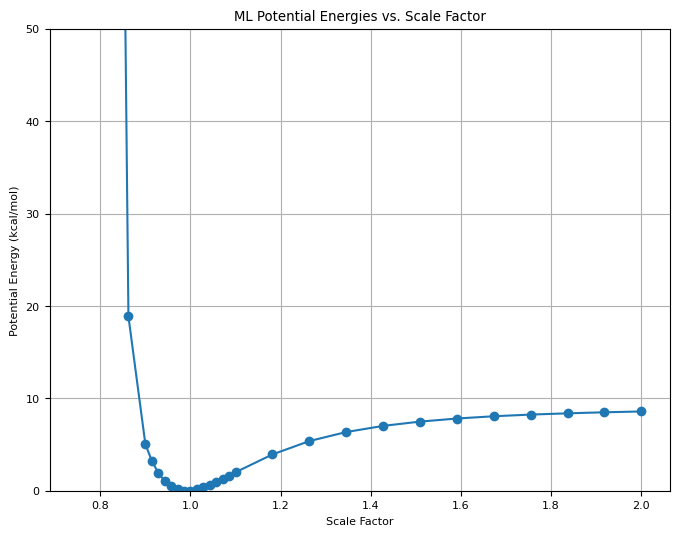

In [ ]:
# Plot the energies of the scaled configurations
plt.figure(figsize=(8, 6))
plt.plot(
    scale_factors, (np.array(energies) - np.array(energies).min()) / N_MOL, marker="o"
)
plt.title("ML Potential Energies vs. Scale Factor")
plt.xlabel("Scale Factor")
plt.ylabel("Potential Energy (kcal/mol)")
plt.ylim(0, 50)
plt.grid(True)

## Modified from Descent...

In [ ]:
"""Train against relative energies and forces."""

import typing

import datasets
import datasets.table
import pyarrow
import smee
import smee.utils
import torch

DATA_SCHEMA = pyarrow.schema(
    [
        ("smiles", pyarrow.string()),
        ("coords", pyarrow.list_(pyarrow.float64())),
        ("box_vectors", pyarrow.list_(pyarrow.float64())),
        ("energy", pyarrow.list_(pyarrow.float64())),
        ("forces", pyarrow.list_(pyarrow.float64())),
    ]
)


class Entry(typing.TypedDict):
    """Represents a set of reference energies and forces."""

    smiles: str
    """The indexed SMILES description of the molecule the energies and forces were
    computed for."""

    coords: torch.Tensor
    """The coordinates [Å] the energies and forces were evaluated at with
    ``shape=(n_confs, n_particles, 3)``."""

    box_vectors: torch.Tensor
    """The box vectors [Å] the energies and forces were evaluated at with
    ``shape=(n_confs, 3, 3)``."""

    energy: torch.Tensor
    """The reference energies [kcal/mol] with ``shape=(n_confs,)``."""
    forces: torch.Tensor
    """The reference forces [kcal/mol/Å] with ``shape=(n_confs, n_particles, 3)``."""


def create_dataset(entries: list[Entry]) -> datasets.Dataset:
    """Create a dataset from a list of existing entries.

    Args:
        entries: The entries to create the dataset from.

    Returns:
        The created dataset.
    """

    table = pyarrow.Table.from_pylist(
        [
            {
                "smiles": entry["smiles"],
                "coords": entry["coords"].clone().detach().flatten().tolist(),
                "box_vectors": entry["box_vectors"].clone().detach().flatten().tolist(),
                "energy": entry["energy"].clone().detach().flatten().tolist(),
                "forces": entry["forces"].clone().detach().flatten().tolist(),
            }
            for entry in entries
        ],
        schema=DATA_SCHEMA,
    )
    # TODO: validate rows
    dataset = datasets.Dataset(datasets.table.InMemoryTable(table))
    dataset.set_format("torch")

    return dataset


def extract_smiles(dataset: datasets.Dataset) -> list[str]:
    """Return a list of unique SMILES strings in the dataset.

    Args:
        dataset: The dataset to extract the SMILES strings from.

    Returns:
        The list of unique SMILES strings.
    """
    return sorted({*dataset.unique("smiles")})


def predict(
    dataset: datasets.Dataset,
    force_field: smee.TensorForceField,
    topologies: dict[str, smee.TensorTopology],
    reference: typing.Literal["mean", "min", "none"] = "none",
    normalize: bool = True,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Predict the relative energies [kcal/mol] and forces [kcal/mol/Å] of a dataset.

    Args:
        dataset: The dataset to predict the energies and forces of.
        force_field: The force field to use to predict the energies and forces.
        topologies: The topologies of the molecules in the dataset. Each key should be
            a fully indexed SMILES string.
        reference: The reference energy to compute the relative energies with respect
            to. This should be either the "mean" energy of all conformers, or the
            energy of the conformer with the lowest reference energy ("min").
        normalize: Whether to scale the relative energies by ``1/sqrt(n_confs_i)``
            and the forces by ``1/sqrt(n_confs_i * n_atoms_per_conf_i * 3)`` This
            is useful when wanting to compute the MSE per entry.

    Returns:
        The predicted and reference relative energies [kcal/mol] with
        ``shape=(n_confs,)``, and predicted and reference forces [kcal/mol/Å] with
        ``shape=(n_confs * n_atoms_per_conf, 3)``.
    """
    energy_ref_all, energy_pred_all = [], []
    forces_ref_all, forces_pred_all = [], []

    for entry in dataset:
        smiles = entry["smiles"]

        energy_ref = entry["energy"]
        forces_ref = entry["forces"].reshape(len(energy_ref), -1, 3)

        coords_flat = smee.utils.tensor_like(
            entry["coords"], force_field.potentials[0].parameters
        )

        coords = (coords_flat.reshape(len(energy_ref), -1, 3)).requires_grad_(True)

        box_vectors_flat = smee.utils.tensor_like(
            entry["box_vectors"], force_field.potentials[0].parameters
        )
        box_vectors = (
            (box_vectors_flat.reshape(len(energy_ref), 3, 3))
            .detach()
            .requires_grad_(False)
        )

        topology = topologies[smiles]

        energy_pred = torch.zeros_like(energy_ref)
        for i, (coord, box_vector) in tqdm(
            enumerate(zip(coords, box_vectors)), total=len(coords)
        ):
            energy_pred[i] = smee.compute_energy(
                topology, force_field, coord, box_vector
            )
        # energy_pred = smee.compute_energy(topology, force_field, coords)
        forces_pred = -torch.autograd.grad(
            energy_pred.sum(),
            coords,
            create_graph=True,
            retain_graph=True,
            allow_unused=False,
        )[0]

        if reference.lower() == "mean":
            energy_ref_0 = energy_ref.mean()
            energy_pred_0 = energy_pred.mean()
        elif reference.lower() == "min":
            min_idx = energy_ref.argmin()

            energy_ref_0 = energy_ref[min_idx]
            energy_pred_0 = energy_pred[min_idx]
        elif reference.lower() == "none":
            energy_ref_0 = 0
            energy_pred_0 = 0
        else:
            raise NotImplementedError(f"invalid reference energy {reference}")

        scale_energy, scale_forces = 1.0, 1.0

        if normalize:
            scale_energy = 1.0 / torch.sqrt(torch.tensor(energy_pred.numel()))
            scale_forces = 1.0 / torch.sqrt(torch.tensor(forces_pred.numel()))

        energy_ref_all.append(scale_energy * (energy_ref - energy_ref_0))
        forces_ref_all.append(scale_forces * forces_ref.reshape(-1, 3))

        energy_pred_all.append(scale_energy * (energy_pred - energy_pred_0))
        forces_pred_all.append(scale_forces * forces_pred.reshape(-1, 3))

    energy_pred_all = torch.cat(energy_pred_all)
    forces_pred_all = torch.cat(forces_pred_all)

    energy_ref_all = torch.cat(energy_ref_all)
    energy_ref_all = smee.utils.tensor_like(energy_ref_all, energy_pred_all)

    forces_ref_all = torch.cat(forces_ref_all)
    forces_ref_all = smee.utils.tensor_like(forces_ref_all, forces_pred_all)

    return (
        energy_ref_all,
        energy_pred_all,
        forces_ref_all,
        forces_pred_all,
    )

## Train the LJ parameters to match the forces from MACE

In [ ]:
LR = 0.01
N_EPOCHS = 100
force_losses = []
energy_losses = []
energy_pred_all = []
forces_pred_all = []
DEVICE = "cuda"

# Move everything to the right device
coords = [c.detach().requires_grad_(True).to(DEVICE) for c in coords_augmented]
box_vectors = [b.to(DEVICE) for b in box_vectors_augmented]
energies = torch.tensor(energies_and_forces["energies"]).to(DEVICE)
forces = torch.tensor(energies_and_forces["forces"]).to(DEVICE)
tensor_ff = tensor_ff.to(DEVICE)
system = system.to(DEVICE)
trainable = descent.train.Trainable(
    force_field=tensor_ff, parameters={"vdW": vdw_parameter_config}, attributes={}
)
x = trainable.to_values()

# Create the dataset again on the right device
entry = Entry(
    smiles=SMILES,
    coords=torch.stack(coords).to(DEVICE),
    box_vectors=torch.stack(box_vectors).to(DEVICE),
    energy=torch.tensor(energies_and_forces["energies"]).to(DEVICE),
    forces=torch.tensor(energies_and_forces["forces"]).to(DEVICE),
)

dataset = create_dataset([entry])

In [ ]:
LR = 0.01
N_EPOCHS = 150
force_losses = []
energy_losses = []
energy_pred_all = []
forces_pred_all = []
DEVICE = "cuda"

# Move everything to the right device
coords = [c.detach().requires_grad_(True).to(DEVICE) for c in coords_augmented]
box_vectors = [b.to(DEVICE) for b in box_vectors_augmented]
energies = torch.tensor(energies_and_forces["energies"]).to(DEVICE)
forces = torch.tensor(energies_and_forces["forces"]).to(DEVICE)
tensor_ff = tensor_ff.to(DEVICE)
system = system.to(DEVICE)
trainable = descent.train.Trainable(
    force_field=tensor_ff, parameters={"vdW": vdw_parameter_config}, attributes={}
)

x = trainable.to_values()
eps = 0.1
with torch.no_grad():
    x += torch.empty_like(x).uniform_(-eps, eps).abs()

# Create the dataset again on the right device
entry = Entry(
    smiles=SMILES,
    coords=torch.stack(coords).to(DEVICE),
    box_vectors=torch.stack(box_vectors).to(DEVICE),
    energy=torch.tensor(energies_and_forces["energies"]).to(DEVICE),
    forces=torch.tensor(energies_and_forces["forces"]).to(DEVICE),
)

dataset = create_dataset([entry])

parameters_init = (
    trainable.to_force_field(trainable.to_values())
    .potentials_by_type["vdW"]
    .parameters.detach()
    .clone()
)


kBT = (
    openmm.unit.AVOGADRO_CONSTANT_NA
    * openmm.unit.BOLTZMANN_CONSTANT_kB
    * 1000
    * openmm.unit.kelvin
).value_in_unit(openmm.unit.kilojoule_per_mole)

# Use only the forces for the loss

optimiser = torch.optim.Adam([x], lr=LR, amsgrad=False)
for epoch in range(N_EPOCHS):
    optimiser.zero_grad()

    energy_ref, energy_pred, forces_ref, forces_pred = predict(
        dataset,
        trainable.to_force_field(x.abs()).to(DEVICE),
        {SMILES: system},
        "min",
        normalize=False,
    )

    normalize = N_MOL

    # Convert to differences in forces or energies between each configuration
    energy_0_idx = energy_ref.argmin()
    energy_ref_diffs = energy_ref / normalize  # - energy_ref[energy_0_idx]
    energy_pred_diffs = energy_pred / normalize  # - energy_pred[energy_0_idx]
    forces_ref_diffs = forces_ref - forces_ref[energy_0_idx]
    forces_pred_diffs = forces_pred - forces_pred[energy_0_idx]

    # Weight
    idx = torch.arange(len(energy_ref), device=energy_ref.device)
    mask = energy_ref_diffs < 15.0
    weights = torch.ones_like(energy_ref_diffs, device=energy_ref.device)
    weights[mask] = torch.exp(-energy_ref_diffs[mask] / kBT)
    weights[~mask] = 0.0
    weights = weights / weights.sum()
    n_force_per_energy = forces_pred_diffs.shape[0] // energy_pred_diffs.shape[0]
    weights_expanded = weights.repeat_interleave(n_force_per_energy)
    weights_expanded = weights_expanded.view(-1, 1).to("cuda")
    print("weights", weights)
    loss_energy = torch.mean(
        weights * (energy_pred_diffs - energy_ref_diffs) ** 2
    ) / torch.var(energy_ref_diffs)
    loss_forces = torch.mean(
        weights_expanded * (forces_pred_diffs - forces_ref_diffs) ** 2
    ) / torch.var(forces_ref_diffs)

    # (grad_energy,) = torch.autograd.grad(
    #    loss_energy, x, create_graph=False, retain_graph=True
    # )
    # (grad_force,) = torch.autograd.grad(
    #    loss_forces, x, create_graph=False, retain_graph=True
    # )
    # x.grad = grad_energy + grad_force
    loss = loss_energy  # + loss_forces
    loss.backward()

    # loss_energy = torch.sqrt(torch.mean((energy_pred - energy_ref)**2))
    # loss_forces = torch.sqrt(torch.mean((forces_pred - forces_ref)**2))

    # (grad, ) = torch.autograd.grad(loss_forces, x, create_graph=False)
    # x.grad = grad

    # pred_energies, pred_forces = get_pred_energies_and_forces(system, trainable.to_force_field(x).to(DEVICE), coords, box_vectors)
    # loss_energy, loss_forces = get_loss(pred_energies, pred_forces, energies, forces, x)

    # (grad,) = torch.autograd.grad(loss_forces, x, create_graph=False)
    # x.grad = grad
    # Move losses to CPU and save as np array
    energy_pred_all.append(energy_pred.detach().cpu().to(torch.float32).numpy())
    forces_pred_all.append(forces_pred.detach().cpu().to(torch.float32).numpy())
    energy_losses.append(loss_energy.detach().cpu().to(torch.float32).numpy())
    force_losses.append(loss_forces.detach().cpu().to(torch.float32).numpy())
    print(f"Epoch {epoch}: loss_energy = {loss_energy}, loss_forces = {loss_forces}")
    # print(x)
    # print(x.grad)
    optimiser.step()
    # x = trainable.clamp(x).requires_grad_(True)
    torch.cuda.empty_cache()

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 57.83it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 0: loss_energy = 4.5195871933856324e-08, loss_forces = 0.1416409643127547


100%|██████████| 30/30 [00:00<00:00, 57.52it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 1: loss_energy = 2.974086754647942e-08, loss_forces = 0.14136079222244866


100%|██████████| 30/30 [00:00<00:00, 64.50it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 2: loss_energy = 1.7819987263578696e-08, loss_forces = 0.14104949486344448


100%|██████████| 30/30 [00:00<00:00, 68.52it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 3: loss_energy = 8.950982177680089e-09, loss_forces = 0.14066557673731567


100%|██████████| 30/30 [00:00<00:00, 65.99it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 4: loss_energy = 2.224011863560804e-09, loss_forces = 0.13992612660767154


100%|██████████| 30/30 [00:00<00:00, 66.05it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 5: loss_energy = 3.4515004188051535e-09, loss_forces = 0.14071394537292004


100%|██████████| 30/30 [00:00<00:00, 52.93it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 6: loss_energy = 3.2286200379871843e-09, loss_forces = 0.14108043635776024


100%|██████████| 30/30 [00:00<00:00, 62.14it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 7: loss_energy = 2.6743929293360225e-09, loss_forces = 0.141314158923428


100%|██████████| 30/30 [00:00<00:00, 62.45it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 8: loss_energy = 2.1158508278773525e-09, loss_forces = 0.14148116625843501


100%|██████████| 30/30 [00:00<00:00, 65.67it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 9: loss_energy = 1.6680405945379562e-09, loss_forces = 0.14160766186400256


100%|██████████| 30/30 [00:00<00:00, 64.20it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 10: loss_energy = 1.3650406360810052e-09, loss_forces = 0.14170725550411326


100%|██████████| 30/30 [00:00<00:00, 62.34it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 11: loss_energy = 1.2032498331038255e-09, loss_forces = 0.1417880397351461


100%|██████████| 30/30 [00:00<00:00, 62.30it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 12: loss_energy = 1.1612147909900727e-09, loss_forces = 0.14185523151110233


100%|██████████| 30/30 [00:00<00:00, 63.81it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 13: loss_energy = 1.2102822077864062e-09, loss_forces = 0.1419123769130372


100%|██████████| 30/30 [00:00<00:00, 66.91it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 14: loss_energy = 1.3206562510248432e-09, loss_forces = 0.14196196998845587


100%|██████████| 30/30 [00:00<00:00, 59.33it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 15: loss_energy = 1.464851906440856e-09, loss_forces = 0.14200581582774963


100%|██████████| 30/30 [00:00<00:00, 59.39it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 16: loss_energy = 1.6195064178603502e-09, loss_forces = 0.14204524073453337


100%|██████████| 30/30 [00:00<00:00, 67.06it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 17: loss_energy = 1.766163437721957e-09, loss_forces = 0.1420812304806594


100%|██████████| 30/30 [00:00<00:00, 67.34it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 18: loss_energy = 1.8913701715916886e-09, loss_forces = 0.14211452671038213


100%|██████████| 30/30 [00:00<00:00, 67.68it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 19: loss_energy = 1.9863981570722444e-09, loss_forces = 0.14214568219148044


100%|██████████| 30/30 [00:00<00:00, 47.28it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 20: loss_energy = 2.046717018089339e-09, loss_forces = 0.14217511869633714


100%|██████████| 30/30 [00:00<00:00, 67.48it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 21: loss_energy = 2.071362414923783e-09, loss_forces = 0.1422031404343835


100%|██████████| 30/30 [00:00<00:00, 66.39it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 22: loss_energy = 2.0622623608801405e-09, loss_forces = 0.14222997445409255


100%|██████████| 30/30 [00:00<00:00, 61.24it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 23: loss_energy = 2.0235479958330416e-09, loss_forces = 0.1422557732519703


100%|██████████| 30/30 [00:00<00:00, 62.48it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 24: loss_energy = 1.9609198709247266e-09, loss_forces = 0.1422806345919309


100%|██████████| 30/30 [00:00<00:00, 58.48it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 25: loss_energy = 1.881026445715861e-09, loss_forces = 0.14230461688272592


100%|██████████| 30/30 [00:00<00:00, 64.24it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 26: loss_energy = 1.7908963201307415e-09, loss_forces = 0.14232772287356998


100%|██████████| 30/30 [00:00<00:00, 61.91it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 27: loss_energy = 1.6974378569400983e-09, loss_forces = 0.14234993703211557


100%|██████████| 30/30 [00:00<00:00, 64.31it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 28: loss_energy = 1.6069737762691716e-09, loss_forces = 0.14237120658553787


100%|██████████| 30/30 [00:00<00:00, 61.64it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 29: loss_energy = 1.5248801110701038e-09, loss_forces = 0.1423914547584517


100%|██████████| 30/30 [00:00<00:00, 55.04it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 30: loss_energy = 1.455287002016803e-09, loss_forces = 0.14241059151975247


100%|██████████| 30/30 [00:00<00:00, 67.79it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 31: loss_energy = 1.4008921800368057e-09, loss_forces = 0.1424285086043111


100%|██████████| 30/30 [00:00<00:00, 64.95it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 32: loss_energy = 1.3628862483017201e-09, loss_forces = 0.14244508794278463


100%|██████████| 30/30 [00:00<00:00, 65.94it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 33: loss_energy = 1.3409900967431554e-09, loss_forces = 0.1424602188935317


100%|██████████| 30/30 [00:00<00:00, 64.73it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 34: loss_energy = 1.3336206583502985e-09, loss_forces = 0.14247378803860566


100%|██████████| 30/30 [00:00<00:00, 60.47it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 35: loss_energy = 1.338159472119571e-09, loss_forces = 0.14248569592197957


100%|██████████| 30/30 [00:00<00:00, 66.42it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 36: loss_energy = 1.3512839736051774e-09, loss_forces = 0.14249586025637842


100%|██████████| 30/30 [00:00<00:00, 67.31it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 37: loss_energy = 1.3693760569921665e-09, loss_forces = 0.14250422707321325


100%|██████████| 30/30 [00:00<00:00, 68.18it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 38: loss_energy = 1.3888995509248048e-09, loss_forces = 0.1425107606877736


100%|██████████| 30/30 [00:00<00:00, 67.93it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 39: loss_energy = 1.4067538245399192e-09, loss_forces = 0.14251546832387757


100%|██████████| 30/30 [00:00<00:00, 67.19it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 40: loss_energy = 1.4205375764575479e-09, loss_forces = 0.14251838515177126


100%|██████████| 30/30 [00:00<00:00, 62.74it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 41: loss_energy = 1.4287123706324678e-09, loss_forces = 0.14251957751749267


100%|██████████| 30/30 [00:00<00:00, 62.42it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 42: loss_energy = 1.4306424933607786e-09, loss_forces = 0.1425191449096535


100%|██████████| 30/30 [00:00<00:00, 65.64it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 43: loss_energy = 1.4265297831883572e-09, loss_forces = 0.1425172157903391


100%|██████████| 30/30 [00:00<00:00, 63.19it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 44: loss_energy = 1.4172606421780642e-09, loss_forces = 0.1425139397462133


100%|██████████| 30/30 [00:00<00:00, 59.35it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 45: loss_energy = 1.4041853235724489e-09, loss_forces = 0.14250948207902694


100%|██████████| 30/30 [00:00<00:00, 66.49it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 46: loss_energy = 1.3888922234528422e-09, loss_forces = 0.14250401980532396


100%|██████████| 30/30 [00:00<00:00, 66.17it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 47: loss_energy = 1.372968849722156e-09, loss_forces = 0.1424977376306417


100%|██████████| 30/30 [00:00<00:00, 62.56it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 48: loss_energy = 1.3578317359375092e-09, loss_forces = 0.14249081314075265


100%|██████████| 30/30 [00:00<00:00, 62.18it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 49: loss_energy = 1.3445770052911143e-09, loss_forces = 0.14248342151929605


100%|██████████| 30/30 [00:00<00:00, 58.28it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 50: loss_energy = 1.333913868251102e-09, loss_forces = 0.14247572901927144


100%|██████████| 30/30 [00:00<00:00, 63.04it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 51: loss_energy = 1.3261470810377318e-09, loss_forces = 0.14246788259774534


100%|██████████| 30/30 [00:00<00:00, 63.41it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 52: loss_energy = 1.3212155813846493e-09, loss_forces = 0.14246001701292788


100%|██████████| 30/30 [00:00<00:00, 65.42it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 53: loss_energy = 1.3187588798757588e-09, loss_forces = 0.14245224227965808


100%|██████████| 30/30 [00:00<00:00, 67.69it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 54: loss_energy = 1.318214981615995e-09, loss_forces = 0.14244465613288548


100%|██████████| 30/30 [00:00<00:00, 62.11it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 55: loss_energy = 1.3189158654114408e-09, loss_forces = 0.14243732829192135


100%|██████████| 30/30 [00:00<00:00, 58.41it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 56: loss_energy = 1.3201791881911618e-09, loss_forces = 0.14243031747254345


100%|██████████| 30/30 [00:00<00:00, 64.46it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 57: loss_energy = 1.321393106046287e-09, loss_forces = 0.14242365539878896


100%|██████████| 30/30 [00:00<00:00, 61.48it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 58: loss_energy = 1.322065235065395e-09, loss_forces = 0.142417360957632


100%|██████████| 30/30 [00:00<00:00, 67.27it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 59: loss_energy = 1.3218584005159073e-09, loss_forces = 0.14241143491594094


100%|██████████| 30/30 [00:00<00:00, 62.90it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 60: loss_energy = 1.3206059579218277e-09, loss_forces = 0.1424058633301779


100%|██████████| 30/30 [00:00<00:00, 54.69it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 61: loss_energy = 1.318299025498959e-09, loss_forces = 0.14240062082989846


100%|██████████| 30/30 [00:00<00:00, 67.51it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 62: loss_energy = 1.315057285289356e-09, loss_forces = 0.14239566840646797


100%|██████████| 30/30 [00:00<00:00, 67.99it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 63: loss_energy = 1.3110964536267034e-09, loss_forces = 0.14239096191553427


100%|██████████| 30/30 [00:00<00:00, 64.17it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 64: loss_energy = 1.3066876469736144e-09, loss_forces = 0.14238644605788575


100%|██████████| 30/30 [00:00<00:00, 65.75it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 65: loss_energy = 1.3021127509560415e-09, loss_forces = 0.14238206412423385


100%|██████████| 30/30 [00:00<00:00, 58.54it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 66: loss_energy = 1.2976312246948396e-09, loss_forces = 0.14237775679580195


100%|██████████| 30/30 [00:00<00:00, 46.31it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 67: loss_energy = 1.2934494586502865e-09, loss_forces = 0.1423734632558819


100%|██████████| 30/30 [00:00<00:00, 63.84it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 68: loss_energy = 1.2897055645666455e-09, loss_forces = 0.14236912672926208


100%|██████████| 30/30 [00:00<00:00, 66.20it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 69: loss_energy = 1.28646371333474e-09, loss_forces = 0.1423646905591293


100%|██████████| 30/30 [00:00<00:00, 59.77it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 70: loss_energy = 1.2837134688581386e-09, loss_forces = 0.14236010574060054


100%|██████████| 30/30 [00:00<00:00, 65.64it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 71: loss_energy = 1.281388994911481e-09, loss_forces = 0.14235532562194825


100%|██████████| 30/30 [00:00<00:00, 58.19it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 72: loss_energy = 1.279376493634743e-09, loss_forces = 0.14235031772276147


100%|██████████| 30/30 [00:00<00:00, 63.75it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 73: loss_energy = 1.2775468460901607e-09, loss_forces = 0.142345054260387


100%|██████████| 30/30 [00:00<00:00, 67.25it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 74: loss_energy = 1.2757663814255693e-09, loss_forces = 0.1423395128879762


100%|██████████| 30/30 [00:00<00:00, 65.84it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 75: loss_energy = 1.2739200805356177e-09, loss_forces = 0.14233368899896118


100%|██████████| 30/30 [00:00<00:00, 66.08it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 76: loss_energy = 1.271919902734453e-09, loss_forces = 0.14232757746687177


100%|██████████| 30/30 [00:00<00:00, 62.33it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 77: loss_energy = 1.2697135565176154e-09, loss_forces = 0.14232118637383823


100%|██████████| 30/30 [00:00<00:00, 59.31it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 78: loss_energy = 1.267287386141902e-09, loss_forces = 0.1423145293158532


100%|██████████| 30/30 [00:00<00:00, 62.47it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 79: loss_energy = 1.2646584890418922e-09, loss_forces = 0.14230762836543775


100%|██████████| 30/30 [00:00<00:00, 66.55it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 80: loss_energy = 1.2618667222241697e-09, loss_forces = 0.1423005087116402


100%|██████████| 30/30 [00:00<00:00, 68.27it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 81: loss_energy = 1.2589713715982498e-09, loss_forces = 0.14229319697913698


100%|██████████| 30/30 [00:00<00:00, 62.18it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 82: loss_energy = 1.2560288364937833e-09, loss_forces = 0.14228572809354795


100%|██████████| 30/30 [00:00<00:00, 62.51it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 83: loss_energy = 1.2530969595303532e-09, loss_forces = 0.1422781312681308


100%|██████████| 30/30 [00:00<00:00, 62.70it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 84: loss_energy = 1.2502167079375681e-09, loss_forces = 0.14227044220412535


100%|██████████| 30/30 [00:00<00:00, 65.96it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 85: loss_energy = 1.2474161703579512e-09, loss_forces = 0.14226268887275775


100%|██████████| 30/30 [00:00<00:00, 63.97it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 86: loss_energy = 1.2447068931109584e-09, loss_forces = 0.14225490188943338


100%|██████████| 30/30 [00:00<00:00, 64.21it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 87: loss_energy = 1.2420823258807445e-09, loss_forces = 0.14224710487895456


100%|██████████| 30/30 [00:00<00:00, 62.09it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 88: loss_energy = 1.2395241499874032e-09, loss_forces = 0.14223932240328124


100%|██████████| 30/30 [00:00<00:00, 63.81it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 89: loss_energy = 1.2370077184797879e-09, loss_forces = 0.1422315674780057


100%|██████████| 30/30 [00:00<00:00, 65.93it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 90: loss_energy = 1.2345059419160975e-09, loss_forces = 0.14222385695079642


100%|██████████| 30/30 [00:00<00:00, 61.76it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 91: loss_energy = 1.2319920639214388e-09, loss_forces = 0.1422161976566404


100%|██████████| 30/30 [00:00<00:00, 62.15it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 92: loss_energy = 1.2294456563921585e-09, loss_forces = 0.14220859174255615


100%|██████████| 30/30 [00:00<00:00, 59.16it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 93: loss_energy = 1.2268488447375603e-09, loss_forces = 0.14220103981282545


100%|██████████| 30/30 [00:00<00:00, 60.65it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 94: loss_energy = 1.2241996305561997e-09, loss_forces = 0.14219353805424426


100%|██████████| 30/30 [00:00<00:00, 65.38it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 95: loss_energy = 1.2214981248703793e-09, loss_forces = 0.14218607761644197


100%|██████████| 30/30 [00:00<00:00, 65.99it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 96: loss_energy = 1.2187509890182469e-09, loss_forces = 0.14217864785014206


100%|██████████| 30/30 [00:00<00:00, 66.43it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 97: loss_energy = 1.2159703244307707e-09, loss_forces = 0.14217123566256806


100%|██████████| 30/30 [00:00<00:00, 62.10it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 98: loss_energy = 1.2131666782266848e-09, loss_forces = 0.14216382822186333


100%|██████████| 30/30 [00:00<00:00, 60.02it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 99: loss_energy = 1.2103541502384019e-09, loss_forces = 0.14215640842975766


100%|██████████| 30/30 [00:00<00:00, 67.78it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 100: loss_energy = 1.2075411781609091e-09, loss_forces = 0.1421489637833279


100%|██████████| 30/30 [00:00<00:00, 62.34it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 101: loss_energy = 1.20473242493091e-09, loss_forces = 0.14214147673058583


100%|██████████| 30/30 [00:00<00:00, 65.15it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 102: loss_energy = 1.2019337747304348e-09, loss_forces = 0.14213393228104554


100%|██████████| 30/30 [00:00<00:00, 62.20it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 103: loss_energy = 1.1991412307565952e-09, loss_forces = 0.1421263181211418


100%|██████████| 30/30 [00:00<00:00, 62.23it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 104: loss_energy = 1.1963544599424836e-09, loss_forces = 0.14211862544582923


100%|██████████| 30/30 [00:00<00:00, 62.20it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 105: loss_energy = 1.1935640253923907e-09, loss_forces = 0.142110842332839


100%|██████████| 30/30 [00:00<00:00, 67.65it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 106: loss_energy = 1.1907645980357984e-09, loss_forces = 0.14210296481123783


100%|██████████| 30/30 [00:00<00:00, 66.52it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 107: loss_energy = 1.1879530692482376e-09, loss_forces = 0.14209498695826275


100%|██████████| 30/30 [00:00<00:00, 65.20it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 108: loss_energy = 1.185122111557746e-09, loss_forces = 0.14208690727860512


100%|██████████| 30/30 [00:00<00:00, 58.47it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 109: loss_energy = 1.1822696155405765e-09, loss_forces = 0.14207872545460828


100%|██████████| 30/30 [00:00<00:00, 65.97it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 110: loss_energy = 1.1793963583528466e-09, loss_forces = 0.14207044343624373


100%|██████████| 30/30 [00:00<00:00, 61.97it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 111: loss_energy = 1.1765014518161365e-09, loss_forces = 0.14206206471333258


100%|██████████| 30/30 [00:00<00:00, 62.63it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 112: loss_energy = 1.1735864502426807e-09, loss_forces = 0.14205359398525863


100%|██████████| 30/30 [00:00<00:00, 64.46it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 113: loss_energy = 1.1706557945245777e-09, loss_forces = 0.1420450397309628


100%|██████████| 30/30 [00:00<00:00, 61.54it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 114: loss_energy = 1.1677103728402471e-09, loss_forces = 0.14203640503150186


100%|██████████| 30/30 [00:00<00:00, 67.79it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 115: loss_energy = 1.164753293814158e-09, loss_forces = 0.14202769980216703


100%|██████████| 30/30 [00:00<00:00, 67.80it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 116: loss_energy = 1.1617876660707793e-09, loss_forces = 0.14201893036923183


100%|██████████| 30/30 [00:00<00:00, 61.45it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 117: loss_energy = 1.1588114912086667e-09, loss_forces = 0.14201010337092876


100%|██████████| 30/30 [00:00<00:00, 60.30it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 118: loss_energy = 1.1558265455846595e-09, loss_forces = 0.14200122377365132


100%|██████████| 30/30 [00:00<00:00, 62.80it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 119: loss_energy = 1.1528318299980356e-09, loss_forces = 0.14199229850601933


100%|██████████| 30/30 [00:00<00:00, 63.28it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 120: loss_energy = 1.149825901158863e-09, loss_forces = 0.141983329449551


100%|██████████| 30/30 [00:00<00:00, 66.73it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 121: loss_energy = 1.1468070937326047e-09, loss_forces = 0.14197432328314152


100%|██████████| 30/30 [00:00<00:00, 67.72it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 122: loss_energy = 1.1437737423847238e-09, loss_forces = 0.14196527862848496


100%|██████████| 30/30 [00:00<00:00, 67.54it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 123: loss_energy = 1.1407265132490352e-09, loss_forces = 0.14195619734686704


100%|██████████| 30/30 [00:00<00:00, 62.27it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 124: loss_energy = 1.13766185361186e-09, loss_forces = 0.14194707820678568


100%|██████████| 30/30 [00:00<00:00, 61.19it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 125: loss_energy = 1.1345805406293152e-09, loss_forces = 0.14193791886394075


100%|██████████| 30/30 [00:00<00:00, 64.06it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 126: loss_energy = 1.1314829073683086e-09, loss_forces = 0.14192871729313764


100%|██████████| 30/30 [00:00<00:00, 62.06it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 127: loss_energy = 1.1283676215612104e-09, loss_forces = 0.14191947050630507


100%|██████████| 30/30 [00:00<00:00, 65.52it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 128: loss_energy = 1.1252370146763724e-09, loss_forces = 0.1419101728871116


100%|██████████| 30/30 [00:00<00:00, 61.56it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 129: loss_energy = 1.1220886442231404e-09, loss_forces = 0.14190082043348273


100%|██████████| 30/30 [00:00<00:00, 57.69it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 130: loss_energy = 1.1189280613166375e-09, loss_forces = 0.14189140690117097


100%|██████████| 30/30 [00:00<00:00, 61.67it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 131: loss_energy = 1.1157509360870677e-09, loss_forces = 0.14188192752547668


100%|██████████| 30/30 [00:00<00:00, 65.78it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 132: loss_energy = 1.1125598220473876e-09, loss_forces = 0.14187237833693378


100%|██████████| 30/30 [00:00<00:00, 67.54it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 133: loss_energy = 1.1093516105731283e-09, loss_forces = 0.14186275438112167


100%|██████████| 30/30 [00:00<00:00, 63.22it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 134: loss_energy = 1.1061279669988267e-09, loss_forces = 0.14185305071068835


100%|██████████| 30/30 [00:00<00:00, 64.58it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 135: loss_energy = 1.1028885582575754e-09, loss_forces = 0.14184326231476763


100%|██████████| 30/30 [00:00<00:00, 64.90it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 136: loss_energy = 1.0996331623047695e-09, loss_forces = 0.1418333884629435


100%|██████████| 30/30 [00:00<00:00, 48.29it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 137: loss_energy = 1.0963602248281745e-09, loss_forces = 0.14182342537619422


100%|██████████| 30/30 [00:00<00:00, 68.03it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 138: loss_energy = 1.0930690796939757e-09, loss_forces = 0.14181336950731296


100%|██████████| 30/30 [00:00<00:00, 67.95it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 139: loss_energy = 1.0897612812144075e-09, loss_forces = 0.14180322316988014


100%|██████████| 30/30 [00:00<00:00, 65.73it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 140: loss_energy = 1.0864336097426985e-09, loss_forces = 0.14179298134567875


100%|██████████| 30/30 [00:00<00:00, 57.88it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 141: loss_energy = 1.0830871755018734e-09, loss_forces = 0.14178264790303535


100%|██████████| 30/30 [00:00<00:00, 62.38it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 142: loss_energy = 1.0797230887149567e-09, loss_forces = 0.14177221823969438


100%|██████████| 30/30 [00:00<00:00, 65.29it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 143: loss_energy = 1.0763394620028066e-09, loss_forces = 0.14176169585678564


100%|██████████| 30/30 [00:00<00:00, 63.08it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 144: loss_energy = 1.0729376276330527e-09, loss_forces = 0.14175108123719793


100%|██████████| 30/30 [00:00<00:00, 65.58it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 145: loss_energy = 1.0695168084495776e-09, loss_forces = 0.141740374927822


100%|██████████| 30/30 [00:00<00:00, 61.60it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 146: loss_energy = 1.0660752280955421e-09, loss_forces = 0.1417295748629042


100%|██████████| 30/30 [00:00<00:00, 62.90it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 147: loss_energy = 1.062614551905483e-09, loss_forces = 0.14171868370283117


100%|██████████| 30/30 [00:00<00:00, 64.13it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 148: loss_energy = 1.0591335586340733e-09, loss_forces = 0.1417077007369169


100%|██████████| 30/30 [00:00<00:00, 64.40it/s]


weights tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0307, 0.0383, 0.0447, 0.0497, 0.0533,
        0.0555, 0.0564, 0.0563, 0.0554, 0.0540, 0.0523, 0.0504, 0.0484, 0.0463,
        0.0444, 0.0352, 0.0296, 0.0263, 0.0243, 0.0230, 0.0220, 0.0214, 0.0209,
        0.0206, 0.0203, 0.0201])
Epoch 149: loss_energy = 1.0556325813482204e-09, loss_forces = 0.14169662472057612


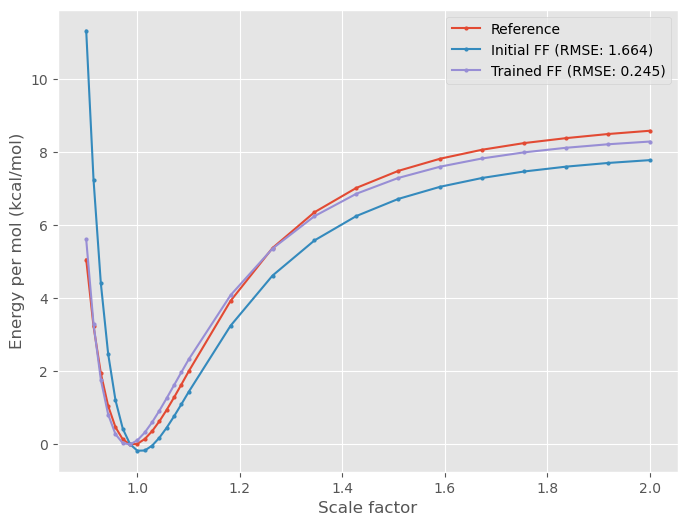

In [ ]:
# Plot the initial energies and final trained energies against the scaling
plt.style.use("ggplot")
ms = 2
fig, ax = plt.subplots(1, 1, figsize=(8, 6))


ref_vals = energy_ref.detach().cpu().numpy() / N_MOL
init_vals = energy_pred_all[0] / N_MOL
final_vals = energy_pred_all[-1] / N_MOL

mask = ref_vals < 15.0
ref_vals = ref_vals[mask]
init_vals = init_vals[mask]
final_vals = final_vals[mask]

rmse_init = np.sqrt(np.mean((init_vals - ref_vals) ** 2))
rmse_final = np.sqrt(np.mean((final_vals - ref_vals) ** 2))

ax.plot(scale_factors[mask], ref_vals, label="Reference", marker="o", ms=ms)
ax.plot(
    scale_factors[mask],
    init_vals,
    label=f"Initial FF (RMSE: {rmse_init:.3f})",
    marker="o",
    ms=ms,
)
ax.plot(
    scale_factors[mask],
    final_vals,
    label=f"Trained FF (RMSE: {rmse_final:.3f})",
    marker="o",
    ms=ms,
)
ax.set_xlabel("Scale factor")
ax.set_ylabel("Energy per mol (kcal/mol)")
ax.legend()

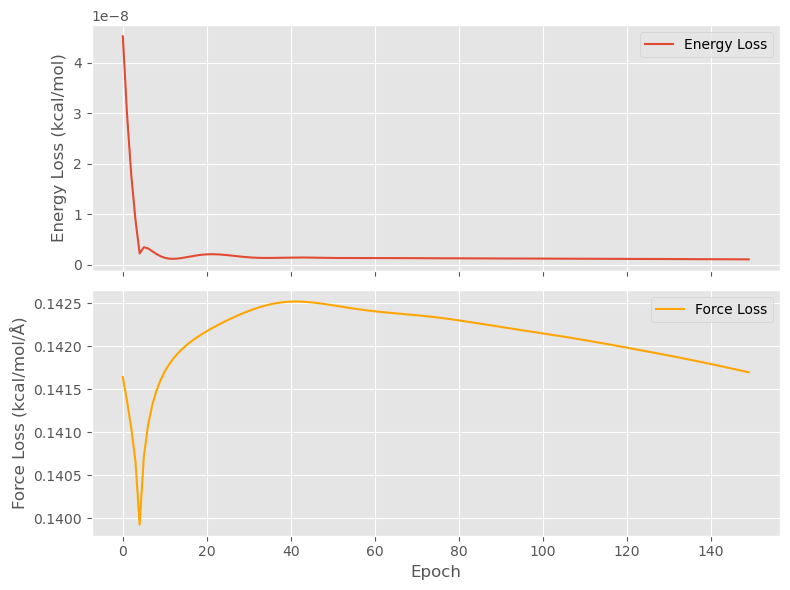

In [ ]:
# Plot the losses
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].plot(energy_losses, label="Energy Loss")
axs[0].set_ylabel("Energy Loss (kcal/mol)")
# axs[0].set_yscale("log")
axs[0].legend()
axs[1].plot(force_losses, label="Force Loss", color="orange")
axs[1].set_ylabel("Force Loss (kcal/mol/Å)")
# axs[1].set_yscale("log")
axs[1].set_xlabel("Epoch")
axs[1].legend()
plt.tight_layout()

In [ ]:
x = x.abs()
print("Initial parameters:")
print(88 * "#")
descent.utils.reporting.print_potential_summary(
    trainable.to_force_field(trainable.to_values()).potentials_by_type["vdW"]
)
print("Final parameters:")
print(88 * "#")
descent.utils.reporting.print_potential_summary(
    trainable.to_force_field(x).potentials_by_type["vdW"]
)

Initial parameters:
########################################################################################
========================================= vdW ==========================================
fn=epsilon*(beta/(alpha-beta)*exp(alpha*(1-r/r_min))-alpha/(alpha-beta)*exp(beta*(1-r/r_min)))

attributes=

scale_12 scale_13 scale_14 scale_15 cutoff [Å] switch_width [Å]    alpha    beta
 0.0000   0.0000   0.5000   1.0000     9.0000           1.0000  16.7663  4.4268 

parameters=

                                  ID epsilon [kcal/mol] r_min [Å]
                            [#6X4:1]             0.1122    3.7925
[#1:1]-[#6X4]-[#7,#8,#9,#16,#17,#35]             0.0229    2.8378
                        [#8X2H1+0:1]             0.2093    3.3335
                         [#1:1]-[#8]             0.0000    1.0000
Final parameters:
########################################################################################
========================================= vdW ==================================

## Calculate the densities and enthalpies

In [ ]:
import descent.targets.thermo

N_REPLICAS = 1
results_final = []
for n in range(N_REPLICAS):
    density_pure = {
        "type": "density",
        "smiles_a": SMILES,
        "x_a": 1.0,
        "smiles_b": None,
        "x_b": None,
        "temperature": 300.0,
        "pressure": 1.0,
        "value": 0.79,
        "std": 0.001,
        "units": "g/mL",
        "source": None,
    }

    hvap = {
        "type": "hvap",
        "smiles_a": SMILES,
        "x_a": 1.0,
        "smiles_b": None,
        "x_b": None,
        "temperature": 300.0,
        "pressure": 1.0,
        "value": 38.30,
        "std": 0.001,
        "units": "kcal/mol",
        "source": None,
    }

    dataset = descent.targets.thermo.create_dataset(density_pure, hvap)
    results = descent.targets.thermo.predict(
        dataset,
        trainable.to_force_field(x).to("cpu"),
        {SMILES: topologies[0]},
        output_dir=Path("./predictions2"),
        cached_dir=Path("./cache2"),
        verbose=True,
    )
    results_final.append(results)

/home/joaomorado/micromamba/envs/des-lj-mace/lib/python3.12/site-packages/torch/autograd/function.py:575: UserWarning: at::frobenius_norm is deprecated and it is just left for JIT compatibility. It will be removed in a future PyTorch release. Please use `linalg.vector_norm(A, 2., dim, keepdim)` instead (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730827426462/work/aten/src/ATen/native/LinearAlgebra.cpp:3063.)
  return super().apply(*args, **kwargs)  # type: ignore[misc]


In [ ]:
# Present averages
dens_list = []
hvap_list = []
for result in results_final:
    dens_list.append(result[2][0].detach().numpy())
    hvap_list.append(result[2][1].detach().numpy() * 4.184)
avg_density = np.mean(dens_list)
avg_hvap = np.mean(hvap_list)
std_density = np.std(dens_list)
std_hvap = np.std(hvap_list)

print(f"Density: {avg_density} ± {std_density} g/mL")
print(f"Hvap: {avg_hvap} ± {std_hvap} kcal/mol")

Density: 0.7705033421516418 ± 0.0 g/mL
Hvap: 35.51038404083252 ± 0.0 kcal/mol


## Run a simulation with the trained force field

In [ ]:
trainable.to_force_field(trainable.to_values()).potentials_by_type["vdW"].parameters

tensor([[0.1122, 3.7925],
        [0.0229, 2.8378],
        [0.2093, 3.3335],
        [0.0000, 1.0000]], device='cuda:0', dtype=torch.float64,
       grad_fn=<ViewBackward0>)

In [ ]:
trained_tensor_ff = trainable.to_force_field(x)
if TRAINED_TRAJECTORY_PATH.exists():
    raise ValueError(f"Trajectory path {TRAINED_TRAJECTORY_PATH} already exists.")

initial_coords, initial_box_vectors = simulate(
    system, trained_tensor_ff, TRAINED_TRAJECTORY_PATH
)

ValueError: Trajectory path methanol_perturbed_rand0_wider_final_ff/trajectory_trained.tr already exists.

##

## Get the predicted condensed phase properties with each force field

In [ ]:
ffs = {"Initial": tensor_ff, "Trained": trained_tensor_ff.to("cpu")}
trajs = {"Initial": TRAJECTORY_PATH, "Trained": TRAINED_TRAJECTORY_PATH}
avgs_and_stds = {}

for name, ff in ffs.items():
    avgs, stds = smee.mm.compute_ensemble_averages(
        system.to("cuda"), ff.to("cuda"), trajs[name], TEMPERATURE, PRESSURE
    )
    avgs_and_stds[name] = {"avgs": avgs, "stds": stds}

In [ ]:
# Print a nice summary table of all
for name, data in avgs_and_stds.items():
    print(f"{name} averages:")
    for prop, value in data["avgs"].items():
        std = data["stds"][prop]
        print(f"  {prop}: {value:.3g} ± {std:.3g}")

Initial averages:
  potential_energy: 417 ± 34.6
  potential_energy^2: 1.75e+05 ± 2.89e+04
  volume: 2.29e+04 ± 438
  volume^2: 5.23e+08 ± 2.01e+07
  density: 0.752 ± 0.0143
  enthalpy: 1.77e+03 ± 46.1
  enthalpy^2: 3.12e+06 ± 1.62e+05
  enthalpy_volume: 4.04e+07 ± 1.5e+06
Trained averages:
  potential_energy: 513 ± 37.1
  potential_energy^2: 2.64e+05 ± 3.78e+04
  volume: 2.44e+04 ± 623
  volume^2: 5.96e+08 ± 3.06e+07
  density: 0.705 ± 0.0178
  enthalpy: 1.86e+03 ± 49.1
  enthalpy^2: 3.46e+06 ± 1.82e+05
  enthalpy_volume: 4.54e+07 ± 1.95e+06
